# Preprocessing Pipeline 4

In [33]:
### imports base

import pandas as pd
import numpy as np
from scipy import stats

### imports analysis

import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations

### imports preprocessing

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler,
                                   FunctionTransformer, PolynomialFeatures, Normalizer)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn import set_config
set_config(transform_output='pandas')

### set up system path to access helpers functions

import sys, os
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
if src_path not in sys.path:
  sys.path.append(src_path)

# import helpers
from helpers import *


In [34]:
### import class balancers

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

### import classifier models

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.inspection import permutation_importance
import shap


- try undersampling, force it look for 1 and not just 0
- select k best
- recursive feature elimination on colab or kaggle server, or some other server

In [35]:
# import merged data

df = pd.read_csv('../data/merged_train.csv')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Feature Engineering

##### DAYS_EMPLOYED_binary

In [36]:
# # create a binary feature for DAYS_EMPLOYED, where unemployed, currently suspected to be indicated by 365243, are 1, else 0

# df['DAYS_EMPLOYED_no_job'] = (df['DAYS_EMPLOYED'] == 365243).astype(int)
# df

OCCUPATION_TYPE_none

In [37]:
# # create a binary feature for OCCUPATION_TYPE, where nulls are 0, everything else is 1

# df['OCCUPATION_TYPE_none'] = (df['OCCUPATION_TYPE'].isna()).astype(int)
# df.head()

# Feature Cleaning

In [38]:
# replace DAYS_EMPLOYED's placeholder value of 365243 with 365

df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243, 365)

# Drop Outliers

In [39]:
# define the outlier remover custom transformer imported from src.helpers

outlier_remover = OutlierRemover(columns=[], iqr_multiplier=5)

# list the features to remove outliers from

outlier_cols = []

# create the preprocessor

preprocessor_outliers = ColumnTransformer([
  ('outlier_remover', outlier_remover, outlier_cols)
], remainder='passthrough', verbose_feature_names_out=False)

# Feature Filter

In [40]:
# create a list of the feature to keep

cols_original_keep = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','CNT_CHILDREN','AMT_INCOME_TOTAL',
             'AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE',
             'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','REGION_POPULATION_RELATIVE','DAYS_BIRTH','DAYS_EMPLOYED',
             'DAYS_REGISTRATION','DAYS_ID_PUBLISH','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL',
             'OCCUPATION_TYPE','CNT_FAM_MEMBERS','REGION_RATING_CLIENT','WEEKDAY_APPR_PROCESS_START',
             'HOUR_APPR_PROCESS_START','REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
             'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY']

cols_engineered_keep = ['num_bureau_records','num_active_bureau_credits','num_closed_bureau_credits','num_bad_bureau_credits',
                        'num_sold_bureau_credits','avg_ratio_bureau_cr_debt','ttl_bureau_cc_limit','ttl_bureau_credit_overdue',
                        'cc_avg_credit_usage_ratio','avg_cc_ATM_ratio','avg_cc_cnt_ATM_drawings','avg_cc_DPD','avg_cc_DPD_DEF',
                        'prev_avg_ratio_credit_approved',
                        'prev_reject_CLIENT','prev_reject_HC','prev_reject_LIMIT','prev_reject_SCO','prev_reject_SCOFR',
                        'prev_reject_SYSTEM','prev_reject_VERIF','prev_reject_XAP','prev_reject_XNA',
                        'prev_status_approved','prev_status_canceled','prev_status_refused','prev_status_unused',
                        'prev_yield_XNA','prev_yield_high','prev_yield_low_action','prev_yield_low_normal',
                        'prev_yield_middle','prev_insured','prev_contract_type_cash','prev_contract_type_consumer',
                        'prev_contract_type_revolving','prev_contract_type_XNA',
                        'prev_client_type_repeater','prev_client_type_new','prev_client_type_refreshed']

cols_original_2_keep = ['DAYS_LAST_PHONE_CHANGE','FLAG_DOCUMENT_3',
                        'FLAG_DOCUMENT_13','FLAG_DOCUMENT_16','FLAG_DOCUMENT_18',
                        'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR',
                        'EXT_SOURCE_2','EXT_SOURCE_1','EXT_SOURCE_3'
                        ]

cols_keep = cols_original_keep + cols_engineered_keep + cols_original_2_keep

cols_drop = ['DAYS_EMPLOYED_no_job','OCCUPATION_TYPE_none',
             'OWN_CAR_AGE','FLAG_MOBIL','FLAG_CONT_MOBILE','REGION_RATING_CLIENT_W_CITY','ORGANIZATION_TYPE',
             'most_recent_bureau_apply','max_days_bureau_overdue',
             'avg_bureau_credit_enddate','max_bureau_overdue_amt','ttl_cnt_bureau_prolong',
             'bureau_type_Auto','bureau_type_Business','bureau_type_Consumer','bureau_type_Real Estate',
             'bureau_type_Other','ttl_bureau_active_annuity','avg_bb_status_sum','avg_bb_status_mean',
             'cc_status_active_ttl','cc_status_completed_ttl','cc_status_negative_ttl','pos_avg_DPD_DEF',
             'pos_status_demand','prev_binary_rejected',
              'PRODUCT_COMBINATION_Card Street','PRODUCT_COMBINATION_Card X-Sell','PRODUCT_COMBINATION_Cash',
              'PRODUCT_COMBINATION_Cash Street: high','PRODUCT_COMBINATION_Cash Street: low',
              'PRODUCT_COMBINATION_Cash Street: middle','PRODUCT_COMBINATION_Cash X-Sell: high',
              'PRODUCT_COMBINATION_Cash X-Sell: low','PRODUCT_COMBINATION_Cash X-Sell: middle',
              'PRODUCT_COMBINATION_POS household with interest','PRODUCT_COMBINATION_POS household without interest',
              'PRODUCT_COMBINATION_POS industry with interest','PRODUCT_COMBINATION_POS industry without interest',
              'PRODUCT_COMBINATION_POS mobile with interest','PRODUCT_COMBINATION_POS mobile without interest',
              'PRODUCT_COMBINATION_POS other with interest','FLAG_DOCUMENT_10','FLAG_DOCUMENT_12','FLAG_DOCUMENT_15',
              'FLAG_DOCUMENT_17']

In [41]:
# create a column transformer to filter unwanted columns

preprocessor_filter = ColumnTransformer([
  ('passthrough', 'passthrough', cols_keep)
], remainder='drop', verbose_feature_names_out=False)

# Imputing

In [42]:
# list the imputing features

impute_freq_cols = ['NAME_CONTRACT_TYPE','CODE_GENDER','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
                    'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','WEEKDAY_APPR_PROCESS_START',
                    'FLAG_OWN_CAR','FLAG_OWN_REALTY']
impute_zero_cols = ['CNT_CHILDREN','num_bureau_records',
                    'num_active_bureau_credits','num_closed_bureau_credits','num_bad_bureau_credits',
                    'num_sold_bureau_credits','avg_ratio_bureau_cr_debt','ttl_bureau_cc_limit','ttl_bureau_credit_overdue',
                    'cc_avg_credit_usage_ratio','avg_cc_ATM_ratio','avg_cc_cnt_ATM_drawings','avg_cc_DPD','avg_cc_DPD_DEF',
                    'prev_reject_CLIENT','prev_reject_HC','prev_reject_LIMIT','prev_reject_SCO','prev_reject_SCOFR',
                    'prev_reject_SYSTEM','prev_reject_VERIF','prev_reject_XAP','prev_reject_XNA']
impute_none_cols = ['OCCUPATION_TYPE']
impute_median_cols = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE',
                      'DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','FLAG_EMP_PHONE',
                      'FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL','REGION_RATING_CLIENT',
                      'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
                      'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY','HOUR_APPR_PROCESS_START',
                      'CNT_FAM_MEMBERS','prev_avg_ratio_credit_approved',
                      'prev_status_approved','prev_status_canceled','prev_status_refused','prev_status_unused',
                      'prev_yield_XNA','prev_yield_high','prev_yield_low_action','prev_yield_low_normal',
                      'prev_yield_middle','prev_insured','prev_contract_type_cash','prev_contract_type_consumer',
                      'prev_contract_type_revolving','prev_contract_type_XNA',
                      'prev_client_type_repeater','prev_client_type_new','prev_client_type_refreshed',
                      'DAYS_LAST_PHONE_CHANGE','FLAG_DOCUMENT_3','FLAG_DOCUMENT_13','FLAG_DOCUMENT_16','FLAG_DOCUMENT_18',
                      'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR','EXT_SOURCE_2',
                      'EXT_SOURCE_1','EXT_SOURCE_3']


# assemble the preprocess

preprocessor_imputing = ColumnTransformer([
  ('impute_most_frequent', SimpleImputer(strategy='most_frequent'), impute_freq_cols),
  ('impute_zero', SimpleImputer(strategy='constant', fill_value=0), impute_zero_cols),
  ('impute_none', SimpleImputer(strategy='constant', fill_value='None'), impute_none_cols),
  ('impute_median', SimpleImputer(strategy='median'), impute_median_cols)
], remainder='passthrough', verbose_feature_names_out=False)


# Encoding

In [43]:
# define the encoders

ohe = OneHotEncoder(drop='if_binary', min_frequency=100, sparse_output=False)

# list the encoding features

ohe_cols = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
            'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START']

# assemble the preprocessor

preprocessor_encoding = ColumnTransformer([
  ('ohe', ohe, ohe_cols),
], remainder='passthrough', verbose_feature_names_out=False)

# Log Transform

In [44]:
# list the log features

log_transform_cols = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','CNT_FAM_MEMBERS']

# create a function transformer to do log transformation

def log_transform_df(X):
  return np.log1p(X)

log_transformer = FunctionTransformer(log_transform_df)


# define the preprocessor

preprocessor_log = ColumnTransformer([
  ('log_transformer', log_transformer, log_transform_cols)
], remainder='passthrough', verbose_feature_names_out=False)

# Scaling

In [45]:
# list the scaling features

standard_scaler_cols = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_BIRTH',
                        'DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','CNT_FAM_MEMBERS','REGION_RATING_CLIENT',
                        'HOUR_APPR_PROCESS_START']

# assemble the preprocessor

preprocessor_scaling = ColumnTransformer([
  ('StandardScaler', StandardScaler(), standard_scaler_cols)
], remainder='passthrough', verbose_feature_names_out=False)

# Train-test-split

In [46]:
# train-test-split

X = df.drop(columns=['SK_ID_CURR','TARGET'])
y = df['TARGET'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Pipeline

In [47]:
# define the main pipe

main_pipe = Pipeline([('preprocessor_filter', preprocessor_filter),
                      ('preprocessor_outliers',preprocessor_outliers),
                      ('preprocessor_imputing', preprocessor_imputing),
                      ('preprocessor_encoding', preprocessor_encoding),
                      ('preprocessor_log', preprocessor_log),
                      ('preprocessor_scaling', preprocessor_scaling)
                      ])

In [48]:
# check the pipe

main_pipe

Pipeline(steps=[('preprocessor_filter',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                                                   'R...
                ('preprocessor_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('StandardScaler',
                                                  StandardScaler(),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'CNT_FAM_MEMBERS',
                                                   'REGION_RATING_CLIENT',
                                                   'HOUR_APPR_PROCESS_START'])],
                                   verbose_feature_names_out=False))])

# Modeling

### 1. Logistic Regression - Undersampling

/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Evaluation
              precision    recall  f1-score   support

           0       0.96      0.61      0.74    226148
           1       0.13      0.67      0.22     19860

    accuracy                           0.62    246008
   macro avg       0.54      0.64      0.48    246008
weighted avg       0.89      0.62      0.70    246008



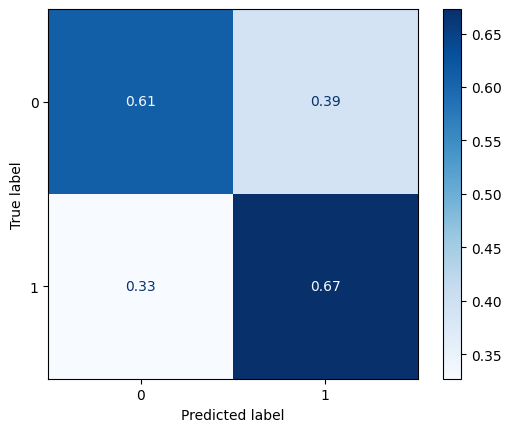

Test Evaluation
              precision    recall  f1-score   support

           0       0.96      0.61      0.75     56538
           1       0.13      0.68      0.22      4965

    accuracy                           0.62     61503
   macro avg       0.55      0.65      0.49     61503
weighted avg       0.89      0.62      0.71     61503



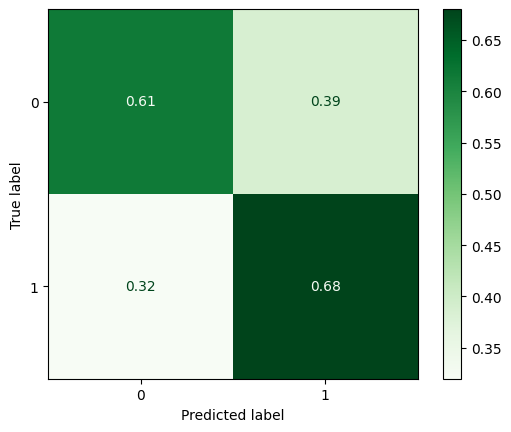

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
LR undersampling,0.615269,0.620181,0.131638,0.13428,0.67286,0.680161,0.220197,0.224281,0.693082,0.699581


In [49]:
# define pipeline for LR
estimators = [step[1] for step in main_pipe.steps]

lr_pipe = make_pipeline(*estimators, RandomUnderSampler(), LogisticRegression(max_iter=1000))

# check the results

model_results,train_pred,test_pred = eval_classification(lr_pipe, X_train, y_train, X_test, y_test, model_name='LR undersampling', pos_label=1)
model_results

### 2. Logistic Regression - Weighted

/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Evaluation
              precision    recall  f1-score   support

           0       0.96      0.61      0.74    226148
           1       0.13      0.68      0.22     19860

    accuracy                           0.61    246008
   macro avg       0.54      0.64      0.48    246008
weighted avg       0.89      0.61      0.70    246008



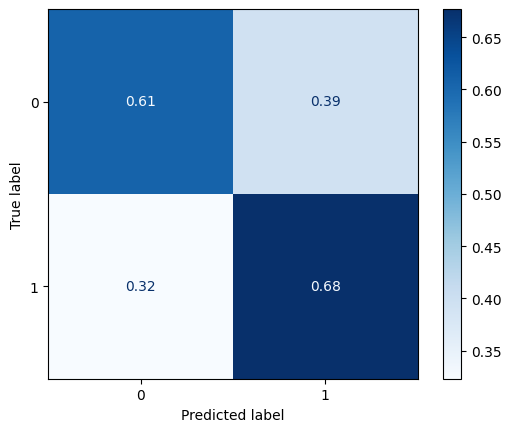

Test Evaluation
              precision    recall  f1-score   support

           0       0.96      0.61      0.75     56538
           1       0.13      0.68      0.22      4965

    accuracy                           0.62     61503
   macro avg       0.54      0.65      0.48     61503
weighted avg       0.89      0.62      0.70     61503



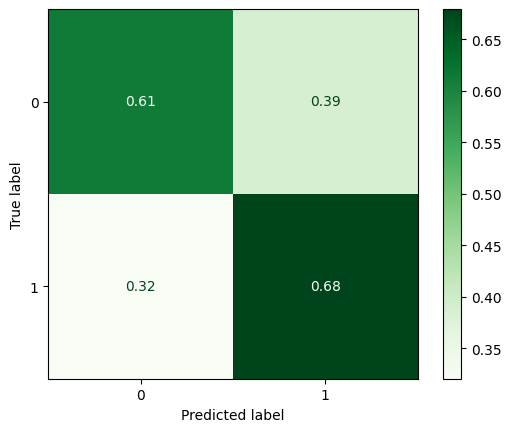

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
LR undersampling,0.615269,0.620181,0.131638,0.13428,0.672860,0.680161,0.220197,0.224281,0.693082,0.699581
LR balanced,0.613078,0.617905,0.131521,0.13342,0.676888,0.679355,0.220247,0.223038,0.692880,0.697400


In [50]:
# define pipeline for LR with weighted classes

estimators = [step[1] for step in main_pipe.steps]

lr_pipe = make_pipeline(*estimators, LogisticRegression(max_iter=1000, class_weight='balanced'))

# check the results

model_results,train_pred,test_pred = eval_classification(lr_pipe, X_train, y_train, X_test, y_test, model_name='LR balanced', pos_label=1,
                                    results_frame=model_results)
model_results

### 3. DecisionTree

Train Evaluation
              precision    recall  f1-score   support

           0       0.96      0.64      0.77    226148
           1       0.15      0.72      0.24     19860

    accuracy                           0.64    246008
   macro avg       0.56      0.68      0.51    246008
weighted avg       0.90      0.64      0.72    246008



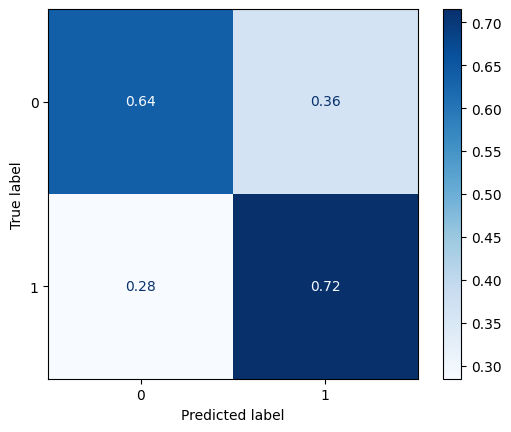

Test Evaluation
              precision    recall  f1-score   support

           0       0.96      0.64      0.77     56538
           1       0.14      0.68      0.24      4965

    accuracy                           0.64     61503
   macro avg       0.55      0.66      0.50     61503
weighted avg       0.89      0.64      0.72     61503



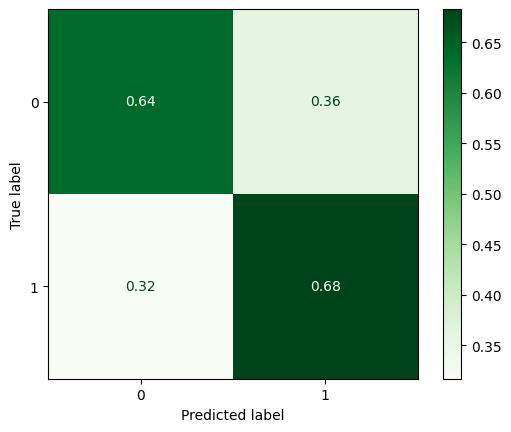

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
LR undersampling,0.615269,0.620181,0.131638,0.134280,0.672860,0.680161,0.220197,0.224281,0.693082,0.699581
LR balanced,0.613078,0.617905,0.131521,0.133420,0.676888,0.679355,0.220247,0.223038,0.692880,0.697400
DecisionTree leaf=100 d=10,0.643853,0.642099,0.147737,0.142306,0.715408,0.682981,0.244900,0.235535,0.738650,0.720207


In [51]:
# define DecisionTree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=100, class_weight='balanced', random_state=42)

estimators = [step[1] for step in main_pipe.steps]
dt_pipe = make_pipeline(*estimators, RandomUnderSampler(), dt)

model_results,train_pred,test_pred = eval_classification(dt_pipe, X_train, y_train, X_test, y_test, model_name='DecisionTree leaf=100 d=10',
                                    results_frame=model_results)
model_results

### 4. XBGClassifier

/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:22:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Train Evaluation
              precision    recall  f1-score   support

           0       0.97      0.71      0.82    226148
           1       0.18      0.73      0.29     19860

    accuracy                           0.71    246008
   macro avg       0.57      0.72      0.55    246008
weighted avg       0.90      0.71      0.77    246008



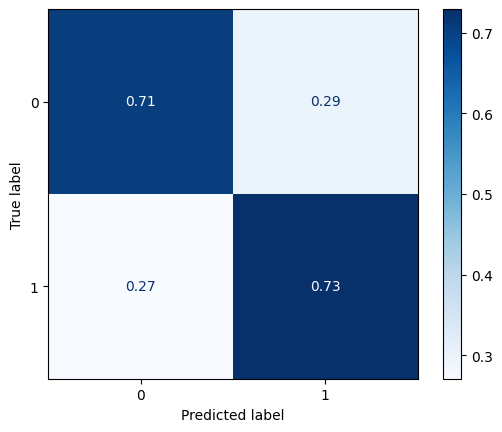

Test Evaluation
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56538
           1       0.17      0.69      0.27      4965

    accuracy                           0.70     61503
   macro avg       0.57      0.70      0.54     61503
weighted avg       0.90      0.70      0.77     61503



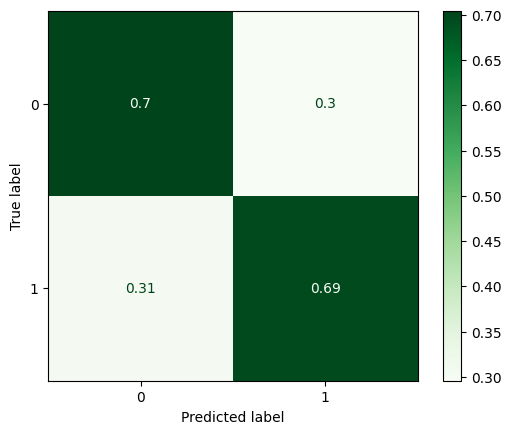

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
LR undersampling,0.615269,0.620181,0.131638,0.134280,0.672860,0.680161,0.220197,0.224281,0.693082,0.699581
LR balanced,0.613078,0.617905,0.131521,0.133420,0.676888,0.679355,0.220247,0.223038,0.692880,0.697400
DecisionTree leaf=100 d=10,0.643853,0.642099,0.147737,0.142306,0.715408,0.682981,0.244900,0.235535,0.738650,0.720207
XGB balanced,0.707115,0.703462,0.178454,0.171021,0.729255,0.694864,0.286741,0.274485,0.791217,0.768012


In [52]:
# define XGBClassifier

xgb = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.1, class_weight='balanced', random_state=42)

estimators = [step[1] for step in main_pipe.steps]
xgb_pipe = make_pipeline(*estimators, RandomUnderSampler(), xgb)

model_results,train_pred,test_pred = eval_classification(xgb_pipe, X_train, y_train, X_test, y_test, model_name='XGB balanced',
                                    results_frame=model_results)
model_results

In [53]:
pd.Series(train_pred).value_counts(normalize=True)

0    0.6701
1    0.3299
Name: proportion, dtype: float64

In [54]:
pd.Series(test_pred).value_counts(normalize=True)

0    0.672
1    0.328
Name: proportion, dtype: float64

In [55]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, train_pred)

array([[159473,  66675],
       [  5377,  14483]])

In [56]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, test_pred)

array([[39815, 16723],
       [ 1515,  3450]])

# Check Feature Importances

In [57]:
# check permutation importances

estimators = [step[1] for step in main_pipe.steps]

# lr_model = make_pipeline(*estimators, LogisticRegression(max_iter=1000, class_weight='balanced')).fit(X_train, y_train)
xgb_model = make_pipeline(*estimators, xgb).fit(X_train, y_train)

/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:22:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


In [58]:
# use SHAP to evaluate feature importances

X_train_proc = main_pipe.transform(X_train.sample(1000))

# explainer = shap.LinearExplainer(lr_model[-1], X_train_proc)
explainer = shap.Explainer(xgb_model[-1], X_train_proc)
shap_values = explainer(X_train_proc)

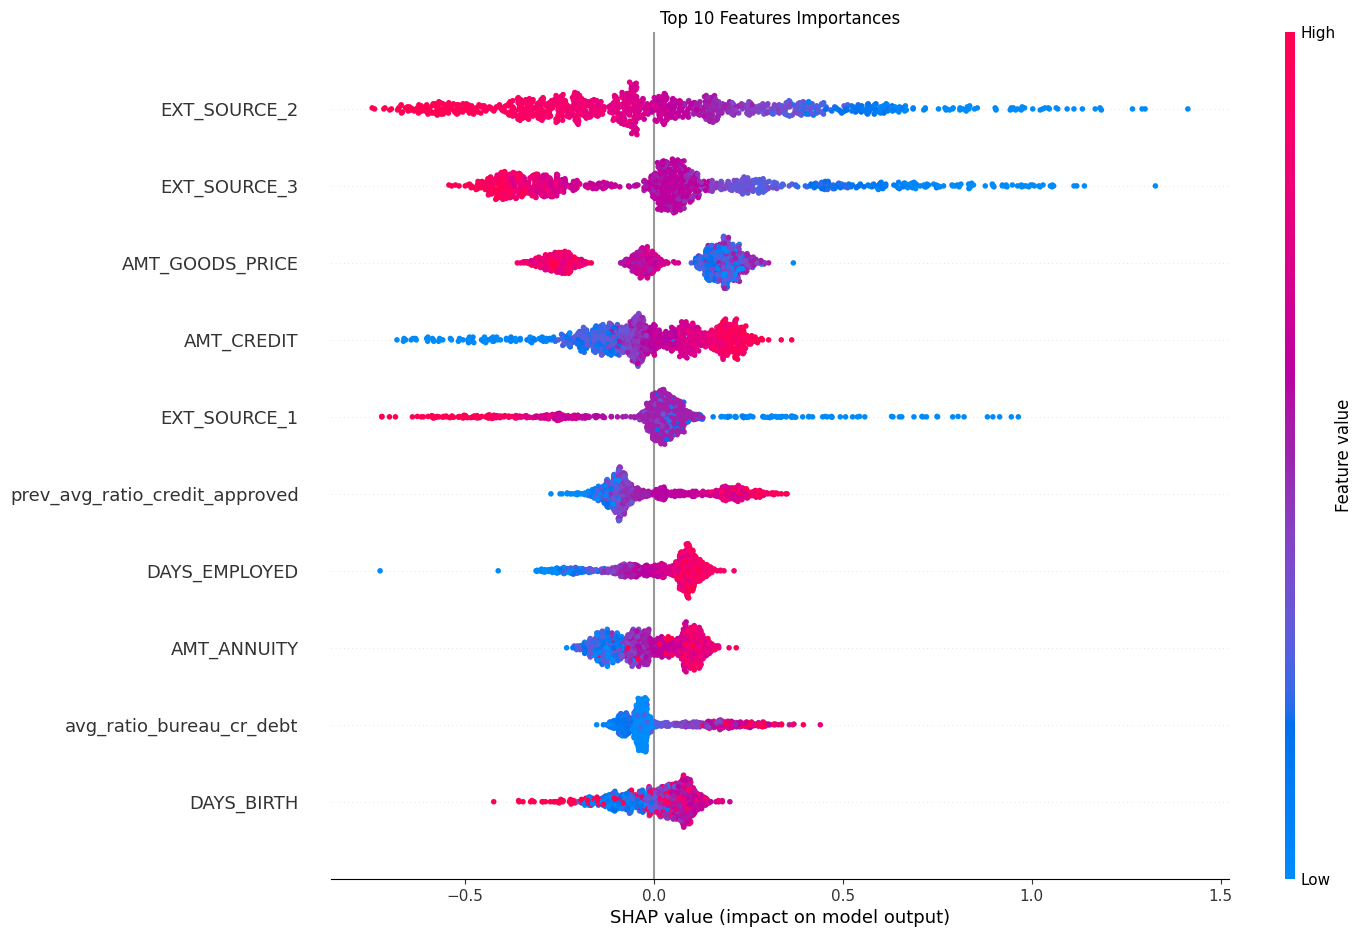

In [59]:
# plot the SHAP summary plot to see the impact of top 50 features

shap.summary_plot(shap_values, X_train_proc, feature_names=X_train_proc.columns, show=False, max_display=10)
plt.gcf().set_size_inches(20,10)
plt.gcf().savefig('shap_plot_10.png', dpi=300)
plt.title('Top 10 Features Importances')
plt.show()

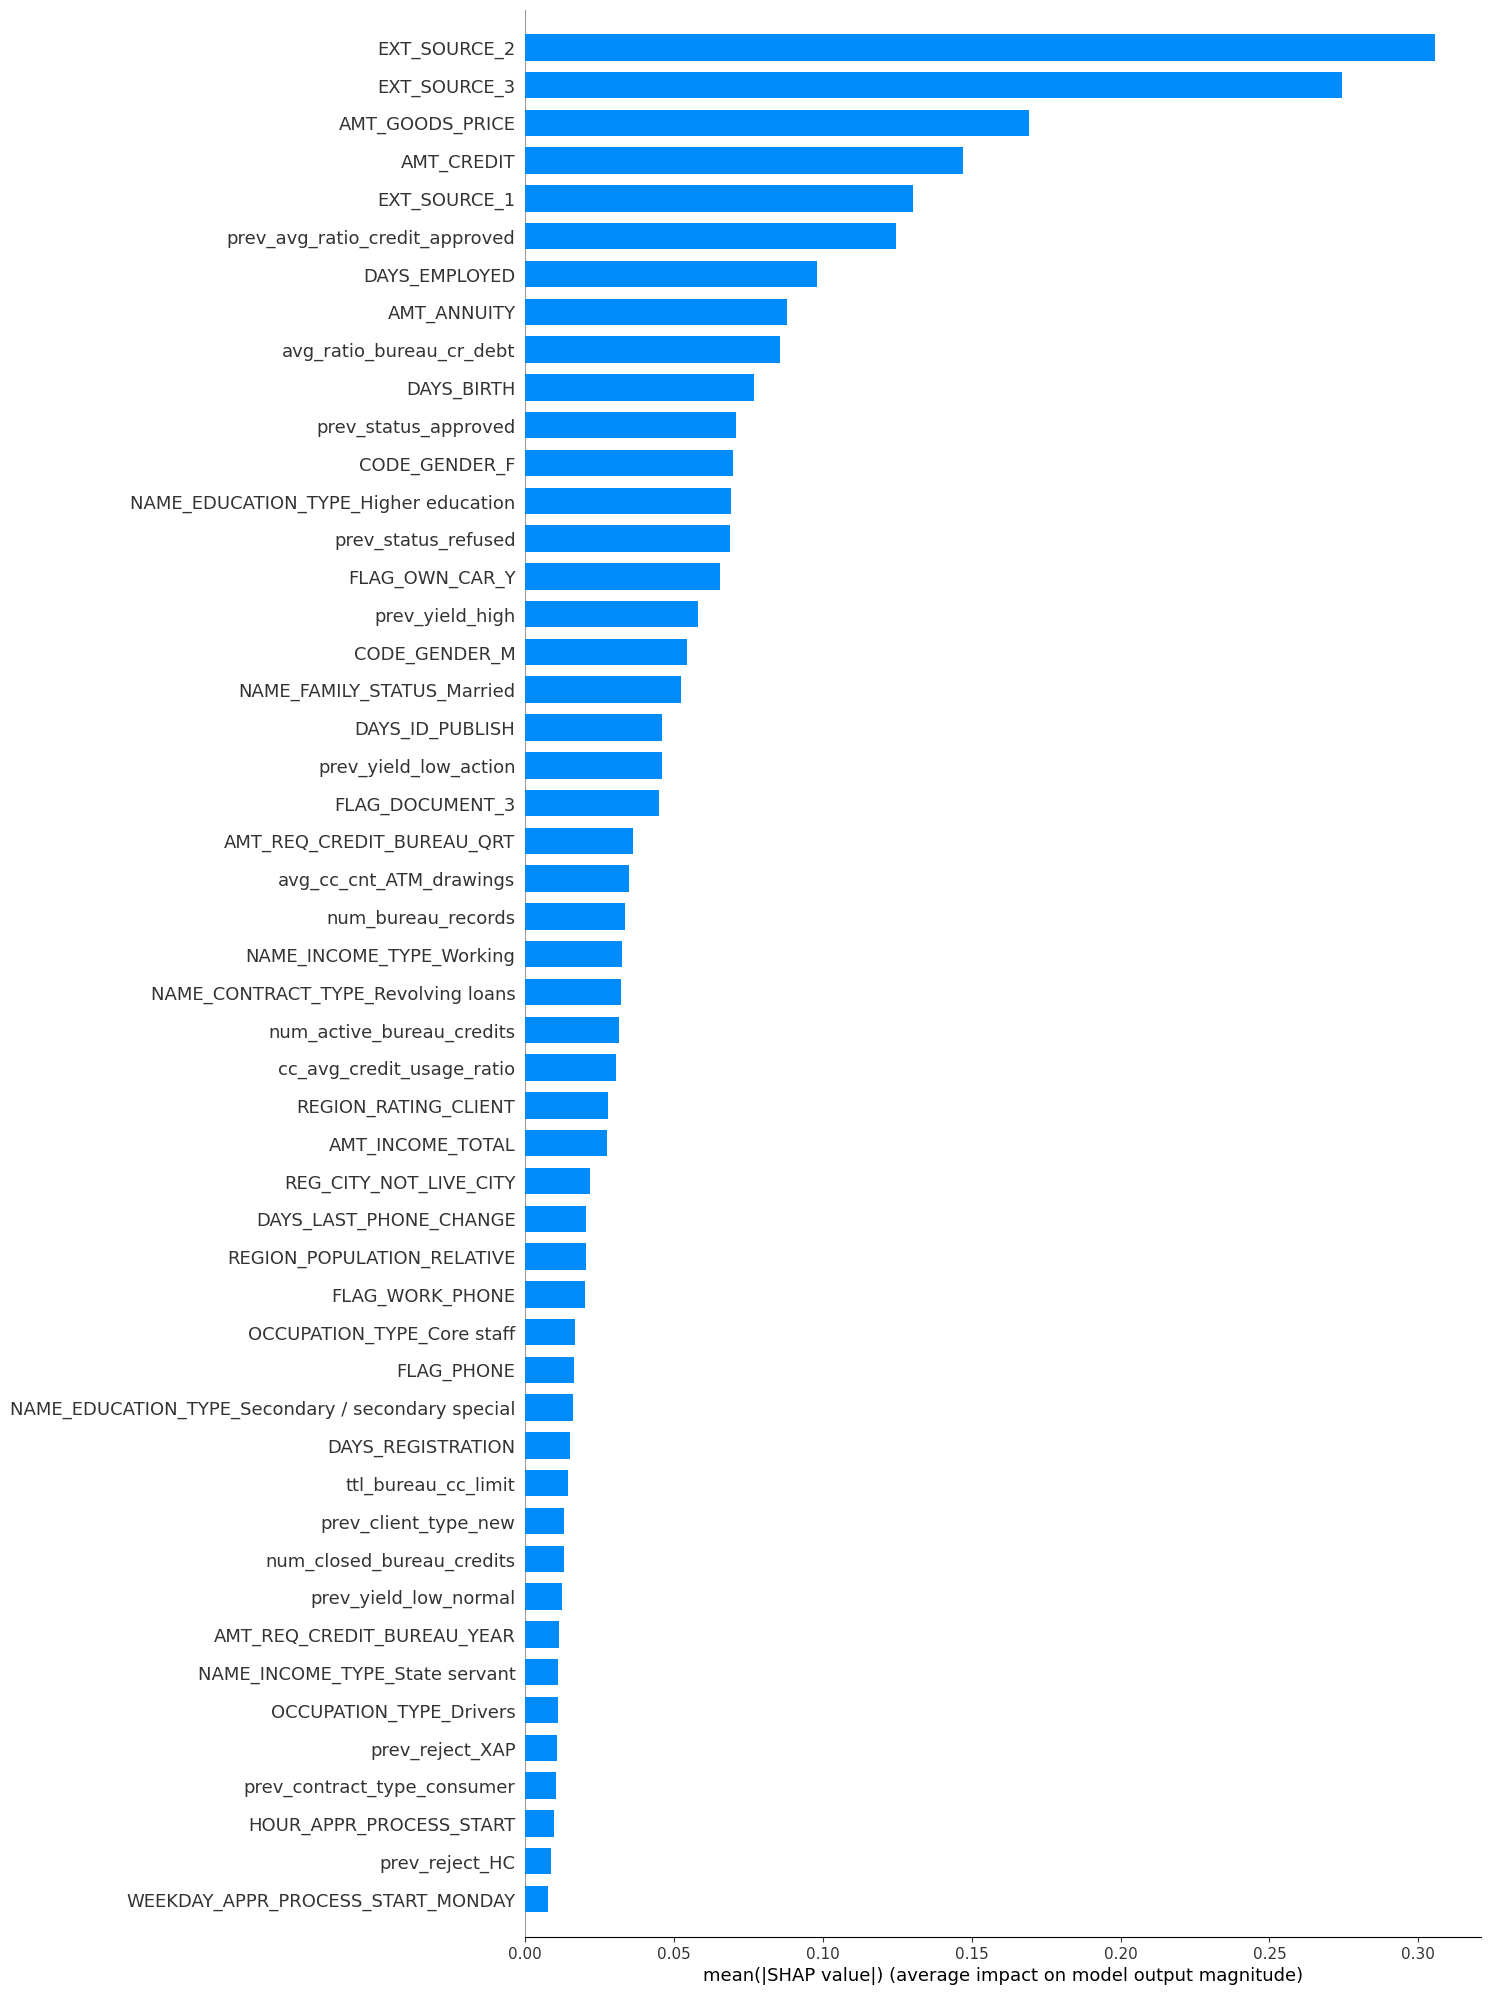

In [60]:
shap.summary_plot(shap_values, X_train_proc, feature_names=X_train_proc.columns, plot_type='bar', max_display=50, show=False)
plt.gcf().set_size_inches(30,20)
plt.show()

In [61]:
# Create a DataFrame with feature importance

feature_importance = np.abs(shap_values.values).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'feature': X_train_proc.columns,
    'importance': feature_importance
})

# get the 20 lowest importances
feature_importance_df.sort_values(by='importance', ascending=True).head(50)

,feature,importance
52,OCCUPATION_TYPE_HR staff,0.000000
29,NAME_INCOME_TYPE_infrequent_sklearn,0.000000
63,OCCUPATION_TYPE_Secretaries,0.000000
23,"NAME_TYPE_SUITE_Spouse, partner",0.000000
61,OCCUPATION_TYPE_Realty agents,0.000000
21,NAME_TYPE_SUITE_Other_A,0.000000
20,NAME_TYPE_SUITE_Group of people,0.000000
60,OCCUPATION_TYPE_Private service staff,0.000000
65,OCCUPATION_TYPE_Waiters/barmen staff,0.000000
66,WEEKDAY_APPR_PROCESS_START_FRIDAY,0.000000


# Predict Test

In [62]:
# import test data

kaggle_test = pd.read_csv('../data/merged_test.csv')

kaggle_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0


In [63]:
# save the id column

kaggle_columns = kaggle_test['SK_ID_CURR']

In [64]:
kaggle_proc = main_pipe.transform(kaggle_test)

In [65]:
kaggle_proc

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,...,FLAG_DOCUMENT_3,FLAG_DOCUMENT_13,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXT_SOURCE_2,EXT_SOURCE_1,EXT_SOURCE_3
0,-0.624036,-0.196844,0.252683,-0.249418,0.078345,-0.736096,-0.184769,-0.051188,1.446789,-0.036092,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.789654,0.752614,0.159520
1,-0.624036,-0.831649,-1.057685,-0.558110,-1.202702,-0.466319,-1.088640,-1.171331,0.909087,-0.036092,...,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.291656,0.564990,0.432962
2,-0.624036,0.633037,0.467459,1.987530,0.548760,-0.918774,-1.083994,0.798566,-0.337373,-0.036092,...,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.699787,0.505446,0.610991
3,2.085938,1.537355,1.676398,1.341103,1.829810,0.470681,0.010788,0.848217,-0.804795,1.793458,...,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.509677,0.525734,0.612704
4,1.085768,0.391966,0.385513,0.564222,0.538738,0.685219,-0.126482,0.280769,-0.840598,0.994257,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.425687,0.202145,0.535276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,-0.624036,-0.412489,-0.196242,-0.547234,-0.635830,-0.903188,-1.384299,-1.164522,-0.268420,-1.488289,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.648575,0.505446,0.643026
48740,2.085938,0.118662,0.378597,0.555208,0.211596,1.110170,0.313628,0.560237,-0.005867,1.793458,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.684596,0.505446,0.535276
48741,1.085768,0.633037,-0.573402,0.628090,-0.420315,0.024643,-0.483807,0.655001,0.987986,0.994257,...,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.632770,0.733503,0.283712
48742,-0.624036,0.848683,-0.074814,0.117828,0.078345,0.472515,-0.354562,1.001145,1.080807,-0.036092,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.445701,0.373090,0.595456


In [66]:
kaggle_preds = xgb_model[-1].predict(kaggle_proc)

In [67]:
kaggle_preds

array([0, 0, 0, ..., 0, 0, 0])

In [68]:
prediction_df = pd.DataFrame({'SK_ID_CURR': kaggle_columns,'TARGET': kaggle_preds})

prediction_df

,SK_ID_CURR,TARGET
0,100001,0
1,100005,0
2,100013,0
3,100028,0
4,100038,0
...,...,...
48739,456221,0
48740,456222,0
48741,456223,0
48742,456224,0


In [69]:
prediction_df['TARGET'].value_counts()

TARGET
0    48631
1      113
Name: count, dtype: int64

In [70]:
113/48744

0.002318234039061218

In [71]:
df['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [72]:
24825/(282686+24825)

0.08072881945686496

In [73]:
# export predictions to submission csv

# prediction_df.to_csv('../submissions/submission2.csv', index=False)

In [77]:
X_test_proc = main_pipe.transform(X_test)

test_pred_2 = xgb_model[-1].predict(X_test_proc)

In [82]:
pd.Series(test_pred_2).value_counts()

0    61262
1      241
Name: count, dtype: int64